# Predictive Maintenance using mechince learning
## Team member: 
     DENG Didan
     LIANG Weijian
     Radik


## Introduction 
Over the past decade, a radical increase in computational power, data storage, and ever-larger volumes of data have reshaped the competitive landscape of diverse industries. The ability to extract meaningful information from large volumes of noisy, disparate data at an industrial scale and integrate such findings into business can offer organizations many benefits. Predictive maintenance is one such critical space, especially for the rail and aviation industries.

Predictive maintenance involves using time-based data from in-service assets such as trains and planes to predict maintenance needs in advance. A key objective of this approach is the ability to correctly predict the right moment to repair or replace a part. If done too far in advance, the benefits of longer usage are lost; if done too late, unexpected failures can result, reducing asset availability. Thus, improving the accuracy of component lifetime predictions is an ongoing goal.

Cutting-edge tools for delivering such predictions include machine learning-based methods. Machine learning is a form of artificial intelligence, in which computers learn to detect complex patterns by analyzing large data sets. Although the basic framework and principles were developed decades ago, the data volumes and computing power that could make machine learning a reality did not exist until recently.


## Data Set

The data set for this Predictive Maintenance consist of two parts:
1. Operation log file

  This part includes the log files of the mechince in past 983 days. In each days, some statics of 26 error types were recorded, such as count, first time occur, last time occur, mean time, and standard deviation, totalling 26*5=130 features perday.
2. Failure record of the target machine.

  This part records the status of the machine for first 683 days.



## Model 
In this project, two types prediction, that is one day in advance prediction and multiple days in advance prediction, are conducted. We emplyed Recurrent Neural Networks， LSTM more precisely, to handle the multiple days in advance prediction as it is suitable for model the  time or sequence dependent behaviour, while the single day in advance prediction is solved by a simpler Neural Networks.

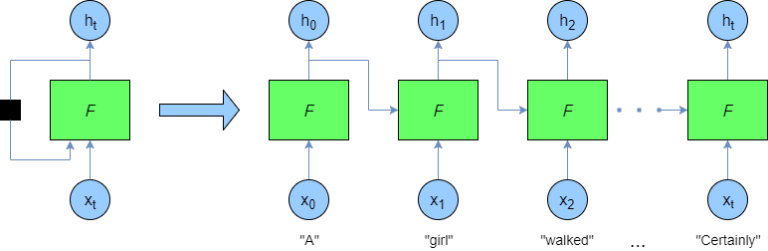
Figure: Illustration of Recurrent Neural Networks

LSTM network is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, the forget gate and the output gate.

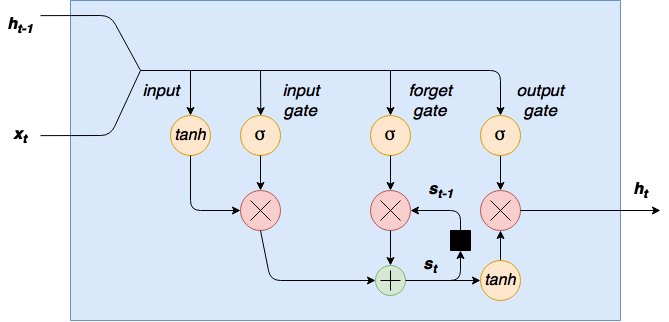
Figure: Graphical representation of the LSTM cell

As shown above, on the left hand side, we have our new word/sequence value being concatenated to the previous output from the cell ht−1ht−1. The first step for this combined input is for it to be squashed via a tanh layer. The second step is that this input is passed through an input gate. An input gate is a layer of sigmoid activated nodes whose output is multiplied by the squashed input. These input gate sigmoids can act to “kill off” any elements of the input vector that aren’t required. A sigmoid function outputs values between 0 and 1, so the weights connecting the input to these nodes can be trained to output values close to zero to “switch off” certain input values (or, conversely, outputs close to 1 to “pass through” other values).

The next step in the flow of data through this cell is the internal state / forget gate loop. LSTM cells have an internal state variable stst. This variable, lagged one time step i.e. st−1st−1 is added to the input data to create an effective layer of recurrence. This addition operation, instead of a multiplication operation, helps to reduce the risk of vanishing gradients. However, this recurrence loop is controlled by a forget gate – this works the same as the input gate, but instead helps the network learn which state variables should be “remembered” or “forgotten”.


## Solution 
The solution for this project is shown as follows:

### Import relevant modulus

In [1]:
import numpy
import pandas
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.merge import concatenate
from keras.models import Model
import tensorflow as tf
from datetime import datetime
import time
from time import gmtime, strftime
import os
import pdb

/home/liang/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Defining some parameters

In [3]:
validation_split= 0.2 #"Split train.csv file into train and validation"
path_save_best_model= './checkpoints/' #"Path to save best model of training"
early_stopping_patience= 40 #"Number of epochs with no improvement after which training will be stopped"
early_stopping_option = "val_acc" # "Quantity to be monitored")
raw_features_data = 'data/feature.xlsx' #"Where the raw features is stored")
raw_train_data = 'data/train_label.csv'# "Where the raw features is stored")
raw_test_data = 'data/test_label_sample.csv' # "Where the raw features is stored")
num_epochs = 20  #"Number of epochs"
batch_size =1 #"Batch size")
task ='multiple_days_advance' #"two types of tasks: one_day_advance prediction or multiple_days_advance prediction")

NOW_DATETIME = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

### Construct the simple neural network

In [5]:
def build_NN_model(features_input):
    features_dense = BatchNormalization()(features_input)
    dense_1 = Dense(128, activation="relu")(features_dense)
    dropout_1 = Dropout(0.5)(dense_1)
    dense_2 = Dense(64, activation="relu")(dropout_1)
    dropout_2 = Dropout(0.2)(dense_2)
    out = Dense(1,kernel_initializer='normal', activation='sigmoid')(dropout_2)
    #out = Dense(2, activation = 'softmax')(dropout_2)
    model = Model(inputs= features_input, outputs=out)
    
    sgd = optimizers.SGD(lr=1e-6, decay=1e-4, momentum=0.9, nesterov=True)
    rmsprop = optimizers.RMSprop(lr=1e-8, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=rmsprop, metrics=['accuracy'])
    #model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model

### Construct the LSTM network

In [6]:
def build_lstm_model(features_input):
    features_dense = BatchNormalization()(features_input)
    lstm_1 = LSTM(128, activation = "relu")(features_dense)
    dropout_1 = Dropout(0.5)(lstm_1)
    dense_1 = Dense(64, activation="relu")(dropout_1)
    dropout_2 = Dropout(0.2)(dense_1)
    out = Dense(1,kernel_initializer='normal', activation='sigmoid')(dropout_2)
    model = Model(inputs = features_input, outputs = out)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    return model

### Define the train function 

In this function, we also record the best-accuracy model

In [7]:
def train(model, train_set):
    if not os.path.exists( os.path.join(path_save_best_model,task)):
        os.mkdir( os.path.join(path_save_best_model,task))
    best_acc_model = os.path.join(path_save_best_model,task,
                                  NOW_DATETIME + "_best_acc.h5")
    early_stopping = EarlyStopping(monitor=early_stopping_option,
                                   patience=early_stopping_patience)
    model_checkpoint_acc = ModelCheckpoint(best_acc_model,
                                           monitor='val_acc',
                                           save_best_only=True,
                                           save_weights_only=True)

    print("Path for best models from training: " + path_save_best_model + "~~.h5")
    #class_weight = get_class_weight(train_set)
    #print(class_weight)
    model.fit(
        train_set[0], train_set[1],
        validation_split=validation_split,
        #class_weight = class_weight,
        epochs=num_epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[early_stopping, model_checkpoint_acc],
        verbose=1)
    print("'Best model from training saved: " + best_acc_model)
    return model

In [8]:

def generate_csv_submission(model, test_features, test_dates):
    # Testing and generating submission csv
    print("Testing model...")
    preds = model.predict(test_features,
                          batch_size=batch_size,
                          verbose=1)

    print("Generating preds_"+ NOW_DATETIME + ".csv ...")
    #tmp =numpy.array( preds[:,1])
    tmp = preds[:,0]
    print(tmp)
    submission = pandas.DataFrame({"label": tmp, "date": test_dates})
    submission.to_csv(NOW_DATETIME+".csv", index=False)

### Load feature

The initial log file is loaded and changed to required format. As the input (matrix) is large and sparse , we delete the some error information which average occurce is less than 1 time / day. At the same time, we fill the 'Nan' with zero.

In [9]:

def load_feature ():
    features = pandas.read_excel('data/feature.xlsx', header = [0,1])
    #print features
    # data clean based on train data
    features.rename(columns = {'Unnamed: 0_level_0': 'DATE'}, inplace = True)
    train_features = features[:683]

    # first, the error types that ocurrence is less than once a day will be masked
    mask_error = []
    for error_type in train_features['count'].keys():
        count_nums = train_features['count'][error_type]
        if numpy.mean(count_nums)<1:
            mask_error.append(error_type)
    
    for stat in features.keys():
        if stat[1] in mask_error:
            features.drop(stat, axis =1, inplace = True)
    
    features.drop(columns = 'DATE', inplace=True)
    features = features.replace(r'mean', numpy.nan, regex = True)
    features = features.fillna(0)
    features = features.as_matrix()
    print features

    return features

### Data Augmentation
Considering the mechine failure is rare ( rate ~ 0.1 ), we manually enlarge the data of the failure information to increase mechine sensitibility on failure occurence, as well as the prediction accuracy.  Increasing the weight of the failure cases on binary classification is also an alternative, however, it is not taken into consideration in current study.

In [10]:
def data_augmentation(features, labels):
    positive_example = []
    for item in zip(features, labels):
        feature = item[0]
        label = item[1]
        if label == 1:
            positive_example.append([feature, label])
    # 10 times the positive example
    for item in positive_example:
        feature = item[0]
        label = item[1]
        for i in range(10):
            features = numpy.concatenate((features,feature.reshape(1,-1)), axis = 0)
            labels = numpy.concatenate((labels, label.reshape((1,))), axis = 0)
    return features, labels

In [11]:
def get_class_weight(train_set):
    # get validation set with even distribution on label
    train_features, train_labels = train_set
    #tmp = train_labels[:,1]
    tmp = train_labels
    zeros_index, = numpy.where(tmp == 0)
    ones_index, = numpy.where(tmp == 1)

    return {0:ones_index.shape[0], 1:zeros_index.shape[0]}

### Prepare input data set and select model
For one day in advance prediction, the simple neural network is used.
The input data dimension is (683, 60) (note that, 683 days information, 60 feature per day after removing part of them)

For multiple day in advance prediction, LSTM is chosen.
That number of days we look back is 20. We also padding the previous days with zeros so that the training and validation data will not reduce.
The input data dimension is (683, 20, 60) (note that, 683 days information, 20 days sequence, 60 feature per day after removing part of them)


In [12]:
def prepare_data_set_and_model():
    # features:from 5/3/2015 to 1/17/2018
    features = load_feature()
    
    # get the train dates and labels
    train_data = pandas.read_csv('data/train_label.csv')
    labels = numpy.array(train_data["label"][1:])
    
    train_labels = labels 
    print ("The number of samples in training set is {}".format(labels.shape[0]))
    
    
    train_features, train_labels = data_augmentation(features[:683], train_labels)
    print(train_features.shape, train_labels.shape)
    # prepare training data
    if task == 'one_day_advance':
        # one day advance: use the features from the day before
        # the last day is 3/23/2017
        #train_features = features[:683]
        input_features = Input(shape=(train_features.shape[1],), dtype = "float32")
        assert train_features.shape[0] == train_labels.shape[0]
        
        model = build_NN_model(input_features)
        
        train_set = [train_features, train_labels]
        
    elif task == 'multiple_days_advance':
        # multiple days advance : use the features from the last 20 days to predict
        # the last day is 3/23/2017
        look_back_days = 20
        train_features = []
        for i in range(683):
            if i < look_back_days-1:
                #padding the previous days with 0
                feature_vec_len = features[0].shape[-1]
                padded_sequence = numpy.concatenate((numpy.zeros((look_back_days-i-1, feature_vec_len)),features[0:i+1]), axis = 0)
                train_features.append(padded_sequence)
            else:
                train_features.append(features[i+1-look_back_days:i+1])
        train_features = numpy.asarray(train_features)

        #assert train_features.shape[0] == train_labels.shape[0]
        
        input_features = Input(shape = (train_features.shape[1], train_features.shape[2]), dtype = "float32")
        
        model = build_lstm_model(input_features)
        
        train_set = [train_features, train_labels[:683]]
        
    test_set = prepare_test_set(features)
    return train_set, test_set, model

In [13]:
def prepare_test_set(features):

    # test_dates : from 3/25/2017 to 1/18/2017
    test_ = pandas.read_csv('data/test_label_sample.csv')
    test_dates = test_["date"]
    test_features = []
    if task == 'one_day_advance':
        # one day advance: use the features from the day before
        test_features = features[-300:]
    elif task == 'multiple_days_advance':
        # multiple days advance : use the features from the last 20 days to predict
        look_back_days = 20
        for i in range(300):
            if i != 299:
                sequence = features[-300-look_back_days+i+1:-300+i+1]
            else:
                sequence = features[-300-look_back_days+i+1:]
                
            test_features.append(sequence)
        test_features = numpy.asarray(test_features)
    return [test_features, test_dates]

In [14]:
train_set, test_set, model = prepare_data_set_and_model()

/home/liang/.local/lib/python2.7/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[[0.00e+00 5.04e+02 2.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 2.25e+03 1.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.70e+03 2.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 ...
 [5.00e+00 1.00e+00 2.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [2.30e+01 1.90e+01 3.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [6.00e+00 1.00e+01 3.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]]
The number of samples in training set is 683
((1123, 60), (1123,))


In [15]:
print(train_set[0].shape, train_set[1].shape)

((683, 20, 60), (683,))


## Training and validation for multiple days in advance prediction
After 1 epoch, the traning accuracy is stable at 0.9432, while the validation accuracy is stable at 0.9051.

In [16]:
model = train(model, train_set)
#model.load_weights("/home/liang/Desktop/6380PROJECT/6380/Midterm/checkpoints/one_day_advance/2018-04-12-06-14-45_best_acc.h5")

Path for best models from training: ./checkpoints/~~.h5
Train on 546 samples, validate on 137 samples
Epoch 1/20
546/546 [==============================] - 8s 15ms/step - loss: 0.8998 - acc: 0.9432 - val_loss: 1.5295 - val_acc: 0.9051
Epoch 2/20
546/546 [==============================] - 8s 14ms/step - loss: 0.9151 - acc: 0.9432 - val_loss: 1.5295 - val_acc: 0.9051
Epoch 3/20
546/546 [==============================] - 8s 14ms/step - loss: 0.9151 - acc: 0.9432 - val_loss: 1.5295 - val_acc: 0.9051
Epoch 4/20
546/546 [==============================] - 8s 14ms/step - loss: 0.9151 - acc: 0.9432 - val_loss: 1.5295 - val_acc: 0.9051
Epoch 5/20
546/546 [==============================] - 8s 14ms/step - loss: 0.9151 - acc: 0.9432 - val_loss: 1.5295 - val_acc: 0.9051
Epoch 6/20
546/546 [==============================] - 8s 14ms/step - loss: 0.9151 - acc: 0.9432 - val_loss: 1.5295 - val_acc: 0.9051
Epoch 7/20
546/546 [==============================] - 8s 14ms/step - loss: 0.9151 - acc: 0.9432 - va

In [ ]:
test_features, test_dates = test_set

In [ ]:
generate_csv_submission(model, test_features, test_dates);

In [17]:
task ='one_day_advance' #"two types of tasks: one_day_advance prediction

In [22]:
def prepare_data_set_and_model():
    # features:from 5/3/2015 to 1/17/2018
    features = load_feature()
    
    # get the train dates and labels
    train_data = pandas.read_csv('data/train_label.csv')
    labels = numpy.array(train_data["label"][1:])
    
    train_labels = labels 
    print ("The number of samples in training set is {}".format(labels.shape[0]))
    
    #features = feature_selection(features, train_labels)
    train_features, train_labels = data_augmentation(features[:683], train_labels)
    print(train_features.shape, train_labels.shape)
    # prepare training data
    if task == 'one_day_advance':
        # one day advance: use the features from the day before
        # the last day is 3/23/2017
        
        input_features = Input(shape=(train_features.shape[1],), dtype = "float32")
        assert train_features.shape[0] == train_labels.shape[0]
        
        model = build_NN_model(input_features)
        
        train_set = [train_features, train_labels]
        
    elif task == 'multiple_days_advance':
        # multiple days advance : use the features from the last 20 days to predict
        # the last day is 3/23/2017
        look_back_days = 20
        train_features = []
        for i in range(683):
            if i < look_back_days-1:
                #padding the previous days with 0
                feature_vec_len = features[0].shape[-1]
                padded_sequence = numpy.concatenate((numpy.zeros((look_back_days-i-1, feature_vec_len)),features[0:i+1]), axis = 0)
                train_features.append(padded_sequence)
            else:
                train_features.append(features[i+1-look_back_days:i+1])
        train_features = numpy.asarray(train_features)

        #assert train_features.shape[0] == train_labels.shape[0]
        
        input_features = Input(shape = (train_features.shape[1], train_features.shape[2]), dtype = "float32")
        
        model = build_lstm_model(input_features)
        
        train_set = [train_features, train_labels[:683]]
        
    test_set = prepare_test_set(features)
    return train_set, test_set, model

In [23]:
train_set2, test_set2, model2 = prepare_data_set_and_model()

[[0.00e+00 5.04e+02 2.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 2.25e+03 1.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.70e+03 2.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 ...
 [5.00e+00 1.00e+00 2.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [2.30e+01 1.90e+01 3.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [6.00e+00 1.00e+01 3.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]]
The number of samples in training set is 683
((1123, 60), (1123,))


In [19]:
print(train_set2[0].shape, train_set2[1].shape)

((1123, 60), (1123,))


## Training and validation for one days in advance prediction
After 1 epoch, the traning accuracy is stable at 0.7116, while the validation accuracy is fluctuating ranging from 0.64 to 0.91

In [24]:
model2 = train(model2, train_set2)

Path for best models from training: ./checkpoints/~~.h5
Train on 898 samples, validate on 225 samples
Epoch 1/20
898/898 [==============================] - 2s 2ms/step - loss: 0.6931 - acc: 0.7116 - val_loss: 5.7309 - val_acc: 0.6444
Epoch 2/20
898/898 [==============================] - 1s 2ms/step - loss: 0.6931 - acc: 0.7116 - val_loss: 3.5818 - val_acc: 0.7778
Epoch 3/20
898/898 [==============================] - 1s 2ms/step - loss: 0.6931 - acc: 0.7116 - val_loss: 2.8654 - val_acc: 0.8222
Epoch 4/20
898/898 [==============================] - 2s 2ms/step - loss: 0.6931 - acc: 0.7116 - val_loss: 2.1491 - val_acc: 0.8667
Epoch 5/20
898/898 [==============================] - 1s 2ms/step - loss: 0.6931 - acc: 0.7116 - val_loss: 4.2982 - val_acc: 0.7333
Epoch 6/20
898/898 [==============================] - 2s 2ms/step - loss: 0.6931 - acc: 0.7116 - val_loss: 3.5818 - val_acc: 0.7778
Epoch 7/20
898/898 [==============================] - 1s 2ms/step - loss: 0.6931 - acc: 0.7116 - val_loss:

## Conclusion
In the project, we adopt simple neural network and LSTM for one day in advance and multiple days in advance prediction. 
1. Before we trainning the network, we remove some weightless features to reduce the dimension of input data set.
2. We manually repeat some failure occurence information to enlarge the model sensitibility on failure occurence. And the performance on test set has increased to 0.5500(The kaggle score ).
3. For one day in advance prediction model, the result is not stable and its validation accuracy fluctuate moderately ranging from 0.64 to 0.91
4. For multiple days in advance prediction model, the performance seems better and its validation accuracy stable at around 90%